In [162]:
import pandas as pd
import re
import os
import numpy as np
import glob
from datetime import datetime
import geopandas as gpd
import json
from shapely.geometry import shape, GeometryCollection
from rasterio.plot import show
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

import shutil
import rasterio

%matplotlib inline

In [163]:
json_folder = r"C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\GeoJson"
img_folder = r'C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\Naver'
tiff_folder = r'C:\Users\yc463\Documents\JamesLocal\DS\Drone\GEOJSONDATA\GeoTiff'

In [164]:
files = glob.glob(os.path.join(tiff_folder,'*.tif'))
files

['C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\아세코밸리골프클럽L18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\오너스GCL18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L15.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\중문골프클럽L18.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTiff\\클럽디거창CCL14.tif',
 'C:\\Users\\yc463\\Documents\\JamesLocal\\DS\\Drone\\GEOJSONDATA\\GeoTif

In [165]:
target_courseName = '오너스'

In [166]:
out_tiff = [ x for x in files if 'L18' in x and target_courseName in x][0]

#### 이미지를 읽어온다 Raterio활용. crs를 5179로

In [167]:
import rasterio
import cv2

with rasterio.open(out_tiff, mode='r+') as dataset:
  image_org = dataset.read()
  image_org = image_org.transpose(1, 2, 0)

In [168]:
dataset.crs

CRS.from_wkt('GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]')

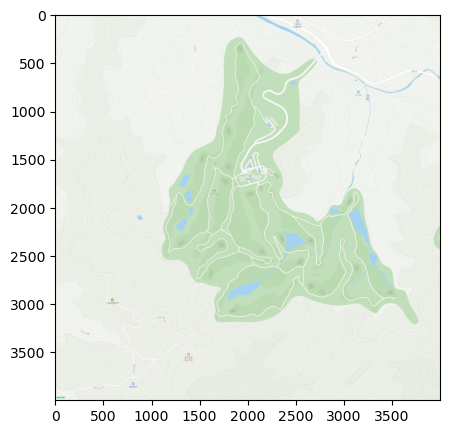

In [169]:
image = cv2.medianBlur(image_org,3)

fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(image)

In [170]:
## Convert to HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

## Mask of green (36,25,25) ~ (86, 255,255)
# mask = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
# 65,  41, 223
#  67,  48, 218
#  68,  38, 206]
mask = cv2.inRange(hsv, (57, 38, 73), (80, 55,217)) # green
# mask = cv2.inRange(hsv, (67, 47, 217), (69, 49,219))
# mask = cv2.inRange(hsv, (24, 29, 217), (76, 77,221))
# (hMin = 65 , sMin = 34, vMin = 126), (hMax = 69 , sMax = 90, vMax = 227)
# (hMin = 64 , sMin = 30, vMin = 191), (hMax = 71 , sMax = 49, vMax = 233)
# mask = cv2.inRange(hsv, (65,30,151), (68, 101,255))
image2 = cv2.bitwise_and(image, image, mask = mask)

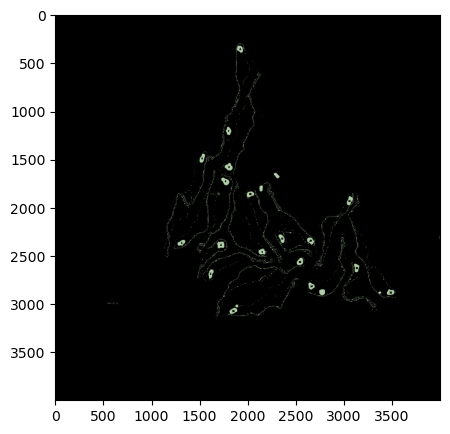

In [171]:
plt.figure(figsize=(5,5))
plt.imshow(image2)
plt.axis('on')
plt.show()

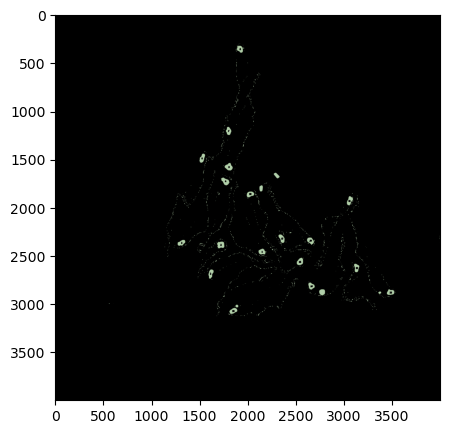

In [172]:
im1_blurred = cv2.medianBlur(image2 ,5)

fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(im1_blurred)

In [173]:
import numpy as np 

pixel_values = im1_blurred.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
k = 2
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

# reshape back to the original image dimension
segmented_image = segmented_image.reshape(im1_blurred.shape)

mask = labels.reshape(im1_blurred.shape[:2]).astype(np.uint8)

if np.where(centers == [0,0,0])[0][0] == 1:
  mask = np.logical_not(mask).astype(np.uint8)

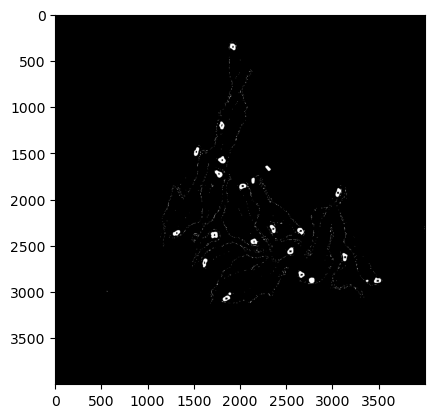

In [174]:
plt.imshow(mask, cmap = 'gray')

In [175]:
contours, hierarchy = cv2.findContours(image=mask.astype(np.uint8), mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)

In [176]:
len(contours)

1481

In [177]:
approx_contours = []

for c in contours:
    epsilon = 0.025*cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c,epsilon,True)
    
    if cv2.contourArea(c) > 500:
        approx_contours.append(approx)
    print(c.shape,approx.shape)

(14, 1, 2) (7, 1, 2)
(8, 1, 2) (4, 1, 2)
(11, 1, 2) (5, 1, 2)
(6, 1, 2) (4, 1, 2)
(16, 1, 2) (6, 1, 2)
(10, 1, 2) (4, 1, 2)
(1, 1, 2) (1, 1, 2)
(12, 1, 2) (7, 1, 2)
(1, 1, 2) (1, 1, 2)
(25, 1, 2) (8, 1, 2)
(2, 1, 2) (2, 1, 2)
(13, 1, 2) (5, 1, 2)
(56, 1, 2) (9, 1, 2)
(15, 1, 2) (8, 1, 2)
(41, 1, 2) (6, 1, 2)
(2, 1, 2) (2, 1, 2)
(6, 1, 2) (2, 1, 2)
(1, 1, 2) (1, 1, 2)
(10, 1, 2) (6, 1, 2)
(28, 1, 2) (12, 1, 2)
(10, 1, 2) (4, 1, 2)
(26, 1, 2) (6, 1, 2)
(27, 1, 2) (7, 1, 2)
(10, 1, 2) (4, 1, 2)
(1, 1, 2) (1, 1, 2)
(1, 1, 2) (1, 1, 2)
(4, 1, 2) (4, 1, 2)
(4, 1, 2) (2, 1, 2)
(20, 1, 2) (7, 1, 2)
(12, 1, 2) (7, 1, 2)
(12, 1, 2) (7, 1, 2)
(4, 1, 2) (2, 1, 2)
(15, 1, 2) (7, 1, 2)
(23, 1, 2) (6, 1, 2)
(16, 1, 2) (5, 1, 2)
(203, 1, 2) (7, 1, 2)
(12, 1, 2) (9, 1, 2)
(13, 1, 2) (7, 1, 2)
(6, 1, 2) (4, 1, 2)
(1, 1, 2) (1, 1, 2)
(17, 1, 2) (8, 1, 2)
(5, 1, 2) (4, 1, 2)
(9, 1, 2) (5, 1, 2)
(2, 1, 2) (2, 1, 2)
(8, 1, 2) (4, 1, 2)
(19, 1, 2) (7, 1, 2)
(15, 1, 2) (7, 1, 2)
(2, 1, 2) (2, 1, 2)
(13, 1, 2)

In [178]:
len(approx_contours)

23

In [179]:
image_copy = image_org.copy()
# c = max(contours, key = cv2.contourArea)
image_copy = cv2.drawContours(image=image_copy, contours=approx_contours, contourIdx=-1, color=(255,1,1), thickness=2, lineType=cv2.LINE_AA)

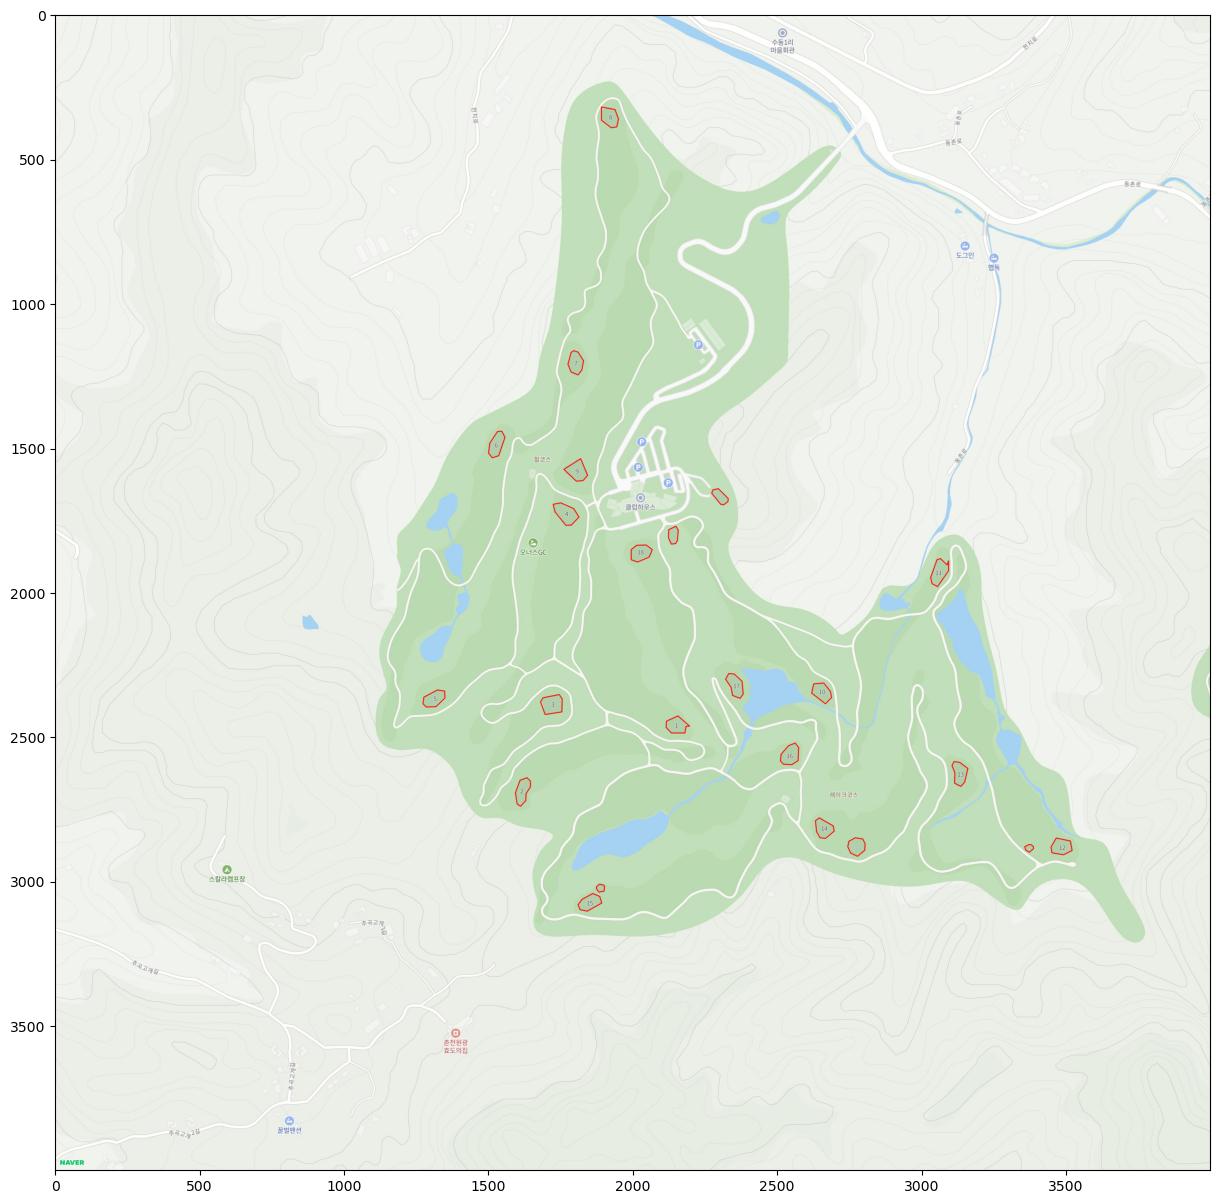

In [180]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.imshow(image_copy)

In [181]:
contours = approx_contours

def convert_latlon(a,dataset_):
    return dataset_.xy(a[1],a[0])

In [182]:
from shapely.geometry import Polygon


con_geo = []
for i,contour in enumerate(contours):
    con_single = np.squeeze(np.apply_along_axis(lambda p: convert_latlon(p, dataset), -1, contour))
    
    try:
        con_single = Polygon(con_single)
        con_geo.append(con_single)
    except:
        pass

In [183]:
gdf = gpd.GeoSeries(con_geo, crs=int(4326))
gdf = gpd.GeoDataFrame(geometry=gdf)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [184]:
gdf['Name']= 'Contour_' + gdf.index.astype(str)
gdf['Client'] = os.path.split(out_tiff)[-1].split('L')[0]

gdf['Course'] = 'TBD'
gdf['Hole'] = gdf.index.astype(str)

gdf['Type'] = '그린'
gdf['Valid'] = True




In [185]:
gdf

,geometry,Name,Client,Course,Hole,Type,Valid
0,"POLYGON ((127.65553 37.76597, 127.65540 37.766...",Contour_0,오너스GC,TBD,0,그린,True
1,"POLYGON ((127.65547 37.76611, 127.65547 37.766...",Contour_1,오너스GC,TBD,1,그린,True
2,"POLYGON ((127.66355 37.76673, 127.66350 37.766...",Contour_2,오너스GC,TBD,2,그린,True
3,"POLYGON ((127.66401 37.76682, 127.66392 37.766...",Contour_3,오너스GC,TBD,3,그린,True
4,"POLYGON ((127.66028 37.76683, 127.66016 37.766...",Contour_4,오너스GC,TBD,4,그린,True
5,"POLYGON ((127.65961 37.76712, 127.65954 37.767...",Contour_5,오너스GC,TBD,5,그린,True
6,"POLYGON ((127.65418 37.76771, 127.65405 37.767...",Contour_6,오너스GC,TBD,6,그린,True
7,"POLYGON ((127.66211 37.76795, 127.66208 37.767...",Contour_7,오너스GC,TBD,7,그린,True
8,"POLYGON ((127.65916 37.76822, 127.65904 37.768...",Contour_8,오너스GC,TBD,8,그린,True
9,"POLYGON ((127.65677 37.76854, 127.65677 37.768...",Contour_9,오너스GC,TBD,9,그린,True


In [186]:
import fiona
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
  gdf.to_file(os.path.join(json_folder,os.path.split(out_tiff)[-1].split('L')[0]+'_그린_'+'.geojson'), driver='GeoJSON')